In [43]:
# !pip install jax[cpu]==0.4.18

In [44]:
import torch
import numpy as np
import scipy.io
import itertools

from scipy.interpolate import griddata, interp1d
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torch.distributions import uniform
from torch.distributions.normal import Normal
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils import data
from torch.autograd import grad

import itertools
from functools import partial
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from tqdm import trange

# import jax.numpy as np
# from jax import random, grad, vmap, jit
# from jax.example_libraries import optimizers
# from jax.experimental.ode import odeint
# from jax.nn import relu, elu
# from jax.config import config
# from jax.flatten_util import ravel_pytree

%matplotlib inline

In [45]:
# from jax import random
# key = random.PRNGKey(54321)
# key

In [46]:
torch.__version__

'2.3.0+cu121'

# Architectures

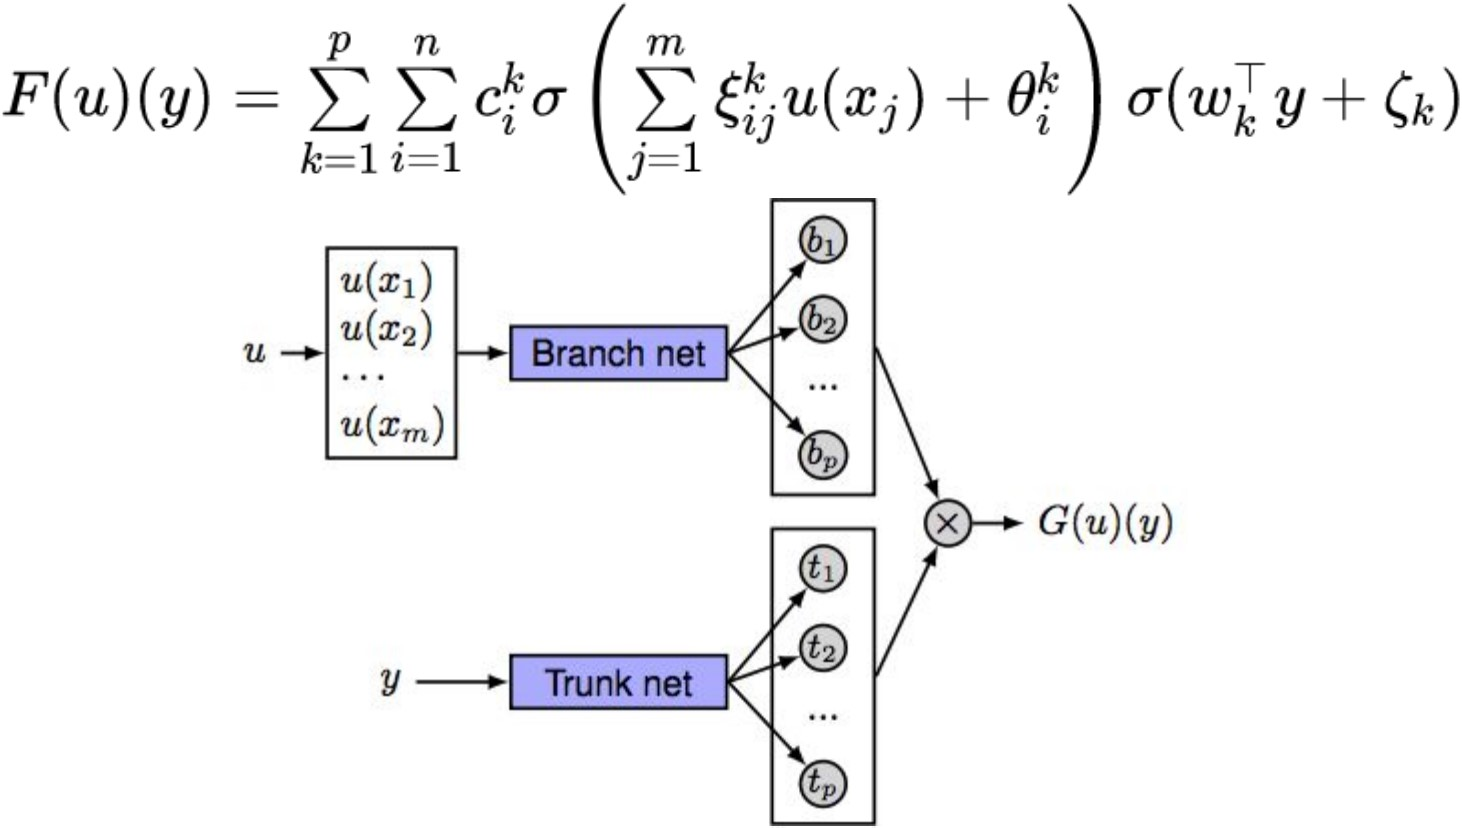

In [47]:
# Define the neural net

# def MLP(layers, activation=F.relu):
#     def xavier_init(d_in, d_out):
#         glorot_stddev = 1. / (d_in + d_out) / 2.
#         W = torch.randn(d_in, d_out) * glorot_stddev
#         b = torch.zeros(d_out)
#         return nn.Parameter(W), nn.Parameter(b)

#     def init(key):
#         U1, b1 = xavier_init(layers[0], layers[1])
#         U2, b2 = xavier_init(layers[0], layers[1])
#         def init_layer(d_in, d_out):
#             W, b = xavier_init(d_in, d_out)
#             return nn.Linear(d_in, d_out)

#         torch.manual_seed(key)
#         key, *keys = torch.randint(0, 10 ** 10, (len(layers),))
#         params = [init_layer(d_in, d_out) for d_in, d_out in zip(layers[:-1], layers[1:])]
#         return (params, U1, b1, U2, b2)

#     def apply(params, inputs):
#         params, U1, b1, U2, b2 = params
#         U = activation(F.linear(inputs, U1, b1))
#         V = activation(F.linear(inputs, U2, b2))
#         for layer in params[:-1]:
#             outputs = activation(layer(inputs))
#             inputs = torch.mul(outputs, U) + torch.mul(1 - outputs, V)
#         outputs = F.linear(inputs, *params[-1].parameters())
#         return outputs

#     return init, apply

class MLP(nn.Module):
    def __init__(self, layers, activation=F.relu):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            nn.init.xavier_uniform_(self.layers[-1].weight)
            nn.init.zeros_(self.layers[-1].bias)

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

# Physics-informed DeepONet

In [48]:
# Define the model
class PI_DeepONet(nn.Module):
    def __init__(self, branch_layers, trunk_layers):
        super(PI_DeepONet, self).__init__()
        self.branch_net = MLP(branch_layers, activation=torch.tanh)
        self.trunk_net = MLP(trunk_layers, activation=torch.tanh)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)

        self.itercount = itertools.count()
        self.loss_log = []
        self.loss_ics_log = []
        self.loss_bcs_log = []
        self.loss_res_log = []

    def operator_net(self, u, t, x):
        y = torch.stack([t, x], dim=-1)
        B = self.branch_net(u)
        T = self.trunk_net(y)
        outputs = torch.sum(B * T, dim=-1)
        return outputs

    def s_t_net(self, u, t, x):
        t.requires_grad_(True)
        s = self.operator_net(u, t, x)
        s_t = torch.autograd.grad(s, t, torch.ones_like(s), create_graph=True)[0]
        return s_t

    def residual_net(self, u, t, x):
        t.requires_grad_(True)
        x.requires_grad_(True)
        s = self.operator_net(u, t, x)
        s_t = torch.autograd.grad(s, t, torch.ones_like(s), create_graph=True)[0]
        s_tt = torch.autograd.grad(s_t, t, torch.ones_like(s_t), create_graph=True)[0]
        s_x = torch.autograd.grad(s, x, torch.ones_like(s), create_graph=True)[0]
        s_xx = torch.autograd.grad(s_x, x, torch.ones_like(s_x), create_graph=True)[0]
        a = 1 / 4
        res = a * s_tt - s_xx
        return res

    def loss_ics(self, u, y, outputs):
        s_pred = self.operator_net(u, y[:, 0], y[:, 1])
        s_t_pred = self.s_t_net(u, y[:, 0], y[:, 1])
        loss_1 = torch.mean((outputs.flatten() - s_pred) ** 2)
        loss_2 = torch.mean(s_t_pred ** 2)
        loss = loss_1 + loss_2
        return loss

    def loss_bcs(self, u, y, outputs):
        s_bc1_pred = self.operator_net(u, y[:, 0], y[:, 1])
        s_bc2_pred = self.operator_net(u, y[:, 2], y[:, 3])
        loss_s_bc1 = torch.mean((s_bc1_pred - outputs[:, 0]) ** 2)
        loss_s_bc2 = torch.mean((s_bc2_pred - outputs[:, 1]) ** 2)
        loss_s_bc = loss_s_bc1 + loss_s_bc2
        return loss_s_bc

    def loss_res(self, u, y):
        pred = self.residual_net(u, y[:, 0], y[:, 1])
        loss = torch.mean(pred ** 2)
        return loss

    def loss(self, ics_batch, bcs_batch, res_batch):
        ics_inputs, ics_outputs = ics_batch
        bcs_inputs, bcs_outputs = bcs_batch
        res_inputs, _ = res_batch

        u_ics, y_ics = ics_inputs
        u_bcs, y_bcs = bcs_inputs
        u_res, y_res = res_inputs

        loss_ics = self.loss_ics(u_ics, y_ics, ics_outputs)
        loss_bcs = self.loss_bcs(u_bcs, y_bcs, bcs_outputs)
        loss_res = self.loss_res(u_res, y_res)

        loss = loss_ics + loss_bcs + loss_res
        return loss

    def step(self, ics_batch, bcs_batch, res_batch):
        self.optimizer.zero_grad()
        loss = self.loss(ics_batch, bcs_batch, res_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter=10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        for _ in pbar:
            ics_batch = next(ics_data)
            bcs_batch = next(bcs_data)
            res_batch = next(res_data)

            loss_value = self.step(ics_batch, bcs_batch, res_batch)
            loss_ics_value = self.loss_ics(ics_batch[0][0], ics_batch[0][1], ics_batch[1])
            loss_bcs_value = self.loss_bcs(bcs_batch[0][0], bcs_batch[0][1], bcs_batch[1])
            loss_res_value = self.loss_res(res_batch[0][0], res_batch[0][1])

            # loss_value = self.loss(ics_batch, bcs_batch, res_batch)
            # loss_ics_value = self.loss_ics(ics_batch)
            # loss_bcs_value = self.loss_bcs(bcs_batch)
            # loss_res_value = self.loss_res(res_batch)

            self.loss_log.append(loss_value)
            self.loss_ics_log.append(loss_ics_value.item())
            self.loss_bcs_log.append(loss_bcs_value.item())
            self.loss_res_log.append(loss_res_value.item())

            pbar.set_postfix({'Loss': loss_value,
                              'loss_ics': loss_ics_value.item(),
                              'loss_bcs': loss_bcs_value.item(),
                              'loss_res': loss_res_value.item()})

    def predict_s(self, U_star, Y_star):
        s_pred = self.operator_net(U_star, Y_star[:, 0], Y_star[:, 1])
        return s_pred

    def predict_res(self, U_star, Y_star):
        r_pred = self.residual_net(U_star, Y_star[:, 0], Y_star[:, 1])
        return r_pred

# Data Generation

In [49]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, batch_size=64, rng_seed=1234):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s

        self.N = u.shape[0]
        self.batch_size = batch_size
        self.rng_seed = rng_seed

    def __getitem__(self, index):
        'Generate one batch of data'
        torch.manual_seed(self.rng_seed)  # Используем rng_seed в качестве seed для нового подключа
        subkey = torch.randint(0, 100000, (1,))
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    def __len__(self):
        'Denotes the total number of samples'
        return self.N // self.batch_size

    def __data_generation(self, subkey):
        'Generates data containing batch_size samples'
        idx = torch.randperm(self.N)[:self.batch_size]
        s = self.s[idx]
        y = self.y[idx]
        u = self.u[idx]

        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [50]:
length_scale = 0.5
output_scale = 10.0
gp_params = (length_scale, output_scale)
c = 1.0


def RBF(X1, X2, gp_params):
    length_scale, output_scale = gp_params
    sqdist = torch.sum(X1 ** 2, 1).reshape(-1, 1) + torch.sum(X2 ** 2, 1) - 2 * torch.matmul(X1, X2.T)
    return output_scale ** 2 * torch.exp(-0.5 / length_scale ** 2 * sqdist + 1e-6)


def generate_one_gaussain_sample(key, gp_params, N):
    length_scale, output_scale = gp_params  # по желанию можно использовать или здесь, или в функции RBF непосредственно
    jitter = 1e-10
    X = torch.linspace(0.0, 1.0, N).reshape(-1, 1)
    K = RBF(X, X, gp_params)
    L = torch.linalg.lu(K + jitter * torch.eye(N))[0]  # LU decomposition

    torch.manual_seed(key)
    normal_dist = Normal(torch.zeros(N), torch.ones(N))
    gp_sample = L @ normal_dist.sample()

    return gp_sample


def generate_one_training_data(key, m=100, P=100, Q=100):
    torch.manual_seed(key)
    subkeys = torch.randint(0, 10 ** 10, (5,))

    # Генерация одного образца ввода
    N = 512
    gp_sample = generate_one_gaussain_sample(int(subkeys[0].item()), gp_params, N)
    x = torch.linspace(0, 1, m)
    X = torch.linspace(0, 1, N).unsqueeze(1)

    def u_fn(x):
        interp_gp = interp1d(X.flatten(), gp_sample.numpy())
        return x * (1 - x) * torch.tensor(interp_gp(x))

    # Входные датчики и измерения
    u = torch.stack([u_fn(x_i) for x_i in x])

    # IC обучающие данные
    u_ic = torch.tile(u, (P, 1))
    t_0 = torch.zeros((P, 1))
    torch.manual_seed(int(subkeys[1].item()))
    x_0 = torch.rand((P, 1))

    y_ic = torch.hstack([t_0, x_0])
    s_ic = torch.stack([u_fn(x_0_i) for x_0_i in x_0])

    # BC обучающие данные
    u_bc = torch.tile(u, (P, 1))

    torch.manual_seed(int(subkeys[2].item()))
    t_bc1 = torch.rand((P, 1))
    x_bc1 = torch.zeros((P, 1))
    torch.manual_seed(int(subkeys[3].item()))
    t_bc2 = torch.rand((P, 1))
    x_bc2 = torch.ones((P, 1))
    y_bc1 = torch.hstack([t_bc1, x_bc1])
    y_bc2 = torch.hstack([t_bc2, x_bc2])
    y_bc = torch.hstack([y_bc1, y_bc2])
    s_bc = torch.zeros((Q, 2))

    # Residual обучающие данные
    u_r = torch.tile(u, (Q, 1))
    torch.manual_seed(int(subkeys[2].item()))
    y_r = torch.rand((Q, 2))
    s_r = torch.zeros((Q, 1))

    return u_ic, y_ic, s_ic, u_bc, y_bc, s_bc, u_r, y_r, s_r


def generate_training_data(key, N, m, P, Q):
    torch.manual_seed(key)
    keys = torch.randint(0, 10 ** 10, (N,))
    # print(keys.shape)

    # # NEED CORRECT
    # u_ic, y_ic, s_ic, u_bc, y_bc, s_bc, u_r, y_r, s_r = \
    #     torch.vmap(generate_one_training_data)(keys, torch.tensor([m]), torch.tensor([P]), torch.tensor([Q]))

    u_ic, y_ic, s_ic = [], [], []
    u_bc, y_bc, s_bc = [], [], []
    u_r, y_r, s_r = [], [], []

    for key in keys:
        u_ic_i, y_ic_i, s_ic_i, u_bc_i, y_bc_i, s_bc_i, u_r_i, y_r_i, s_r_i\
            = generate_one_training_data(key, m, P, Q)
        u_ic.append(u_ic_i)
        y_ic.append(y_ic_i)
        s_ic.append(s_ic_i)

        u_bc.append(u_bc_i)
        y_bc.append(y_bc_i)
        s_bc.append(s_bc_i)

        u_r.append(u_r_i)
        y_r.append(y_r_i)
        s_r.append(s_r_i)

    u_ic, y_ic, s_ic = torch.stack(u_ic), torch.stack(y_ic), torch.stack(s_ic)
    u_bc, y_bc, s_bc = torch.stack(u_bc), torch.stack(y_bc), torch.stack(s_bc)
    u_r, y_r, s_r = torch.stack(u_r), torch.stack(y_r), torch.stack(s_r)

    u_ic_train = u_ic.view(N * P, -1).float()
    y_ic_train = y_ic.view(N * P, -1).float()
    s_ic_train = s_ic.view(N * P, -1).float()

    u_bc_train = u_bc.view(N * P, -1).float()
    y_bc_train = y_bc.view(N * P, -1).float()
    s_bc_train = s_bc.view(N * P, -1).float()

    u_r_train = u_r.view(N * Q, -1).float()
    y_r_train = y_r.view(N * Q, -1).float()
    s_r_train = s_r.view(N * Q, -1).float()

    return u_ic_train, y_ic_train, s_ic_train, u_bc_train, y_bc_train, s_bc_train, u_r_train, y_r_train, s_r_train

# Training a DeepOnet


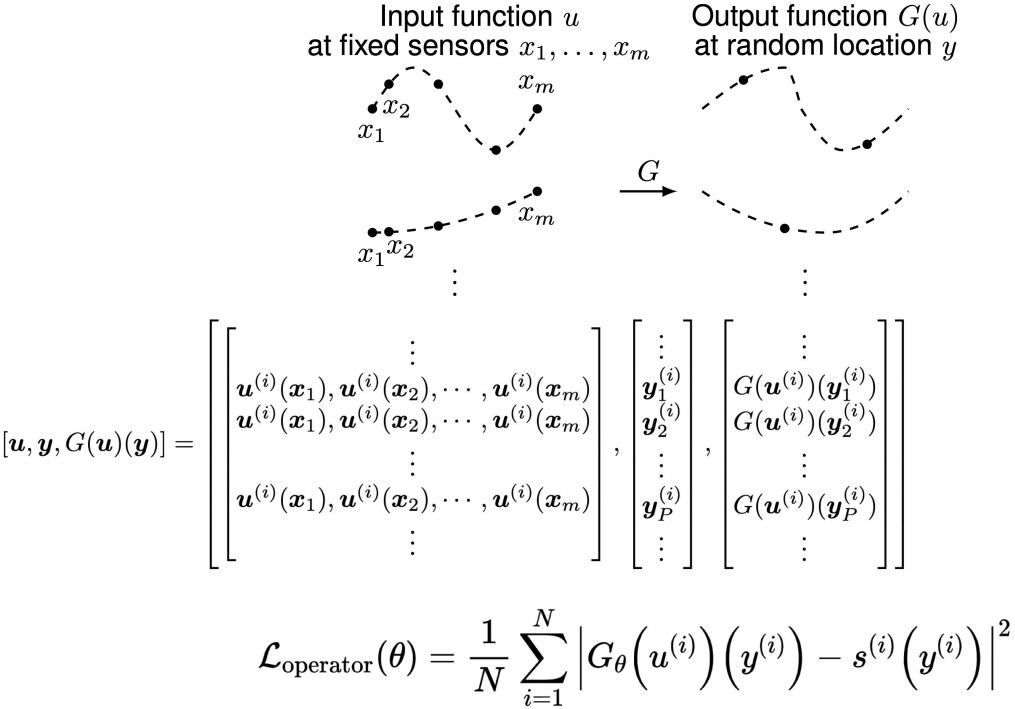

In [51]:
# Generate training data
N_train = 441
N_test = 21
m = 21
P_train = 21
Q_train = 21

In [52]:
# Generate training data
torch.manual_seed(0)  # use different key for generating training data
key_train = torch.randint(0, 10 ** 10, (1, ))
u_ics_train, y_ics_train, s_ics_train, u_bcs_train, y_bcs_train, s_bcs_train, u_res_train, y_res_train, s_res_train = \
    generate_training_data(key_train, N_train, m, P_train, Q_train)


In [53]:
print('u_ics_train =', u_ics_train, '\ny_ics_train =', y_ics_train, '\ns_ics_train =', s_ics_train)
print('u_bcs_train =', u_bcs_train, '\ny_bcs_train =', y_bcs_train, '\ns_bcs_train =', s_res_train)
print('u_res_train =', u_res_train, '\ny_res_train =', y_res_train, '\ns_res_train =', s_res_train)

u_ics_train = tensor([[-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],
        [-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],
        [-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],
        ...,
        [ 0.0000, -0.0067,  0.0060,  ...,  0.1370,  0.0102,  0.0000],
        [ 0.0000, -0.0067,  0.0060,  ...,  0.1370,  0.0102,  0.0000],
        [ 0.0000, -0.0067,  0.0060,  ...,  0.1370,  0.0102,  0.0000]]) 
y_ics_train = tensor([[0.0000, 0.5029],
        [0.0000, 0.5609],
        [0.0000, 0.8763],
        ...,
        [0.0000, 0.0648],
        [0.0000, 0.0883],
        [0.0000, 0.9190]]) 
s_ics_train = tensor([[ 0.4305],
        [-0.2153],
        [ 0.0105],
        ...,
        [ 0.0046],
        [ 0.0318],
        [-0.0550]])
u_bcs_train = tensor([[-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],
        [-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],
        [-0.0000, -0.0167, -0.0030,  ..., -0.0719, -0.0150,  0.0000],


In [54]:
# Initialize model
neurons = 50
branch_layers = [m, neurons, neurons, neurons, neurons]
trunk_layers =  [2, neurons, neurons, neurons, neurons]
model = PI_DeepONet(branch_layers, trunk_layers)

In [55]:
model

PI_DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
)

In [56]:
print(model)

PI_DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=21, out_features=50, bias=True)
      (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=50, bias=True)
      (1-3): 3 x Linear(in_features=50, out_features=50, bias=True)
    )
  )
)


In [57]:
# Create data set
batch_size = 512
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [58]:
# # Train
# model.train(ics_dataset, bcs_dataset, res_dataset, nIter=20000)

In [59]:
# # Получение параметров модели
# params = model.state_dict()

In [60]:
# # Save the trained model and losses
# torch.save(params, 'wave_params_new.pth')
# np.save('wave_loss_res_new.npy', np.array(model.loss_res_log))
# np.save('wave_loss_ics_new.npy', np.array(model.loss_ics_log))
# np.save('wave_loss_bcs_new.npy', np.array(model.loss_bcs_log))

In [61]:
# Restore the trained model
flat_params = torch.load('wave_params_1024.pth')
loss_ics = np.load('wave_loss_ics_1024.npy')
loss_bcs = np.load('wave_loss_bcs_1024.npy')
loss_res = np.load('wave_loss_res_1024.npy')

In [62]:
# Загрузка модели
params = model.parameters(flat_params)

# Plot

In [63]:
# Настройка графиков
plt.rc('font', family='serif')
plt.rcParams.update(plt.rcParamsDefault)

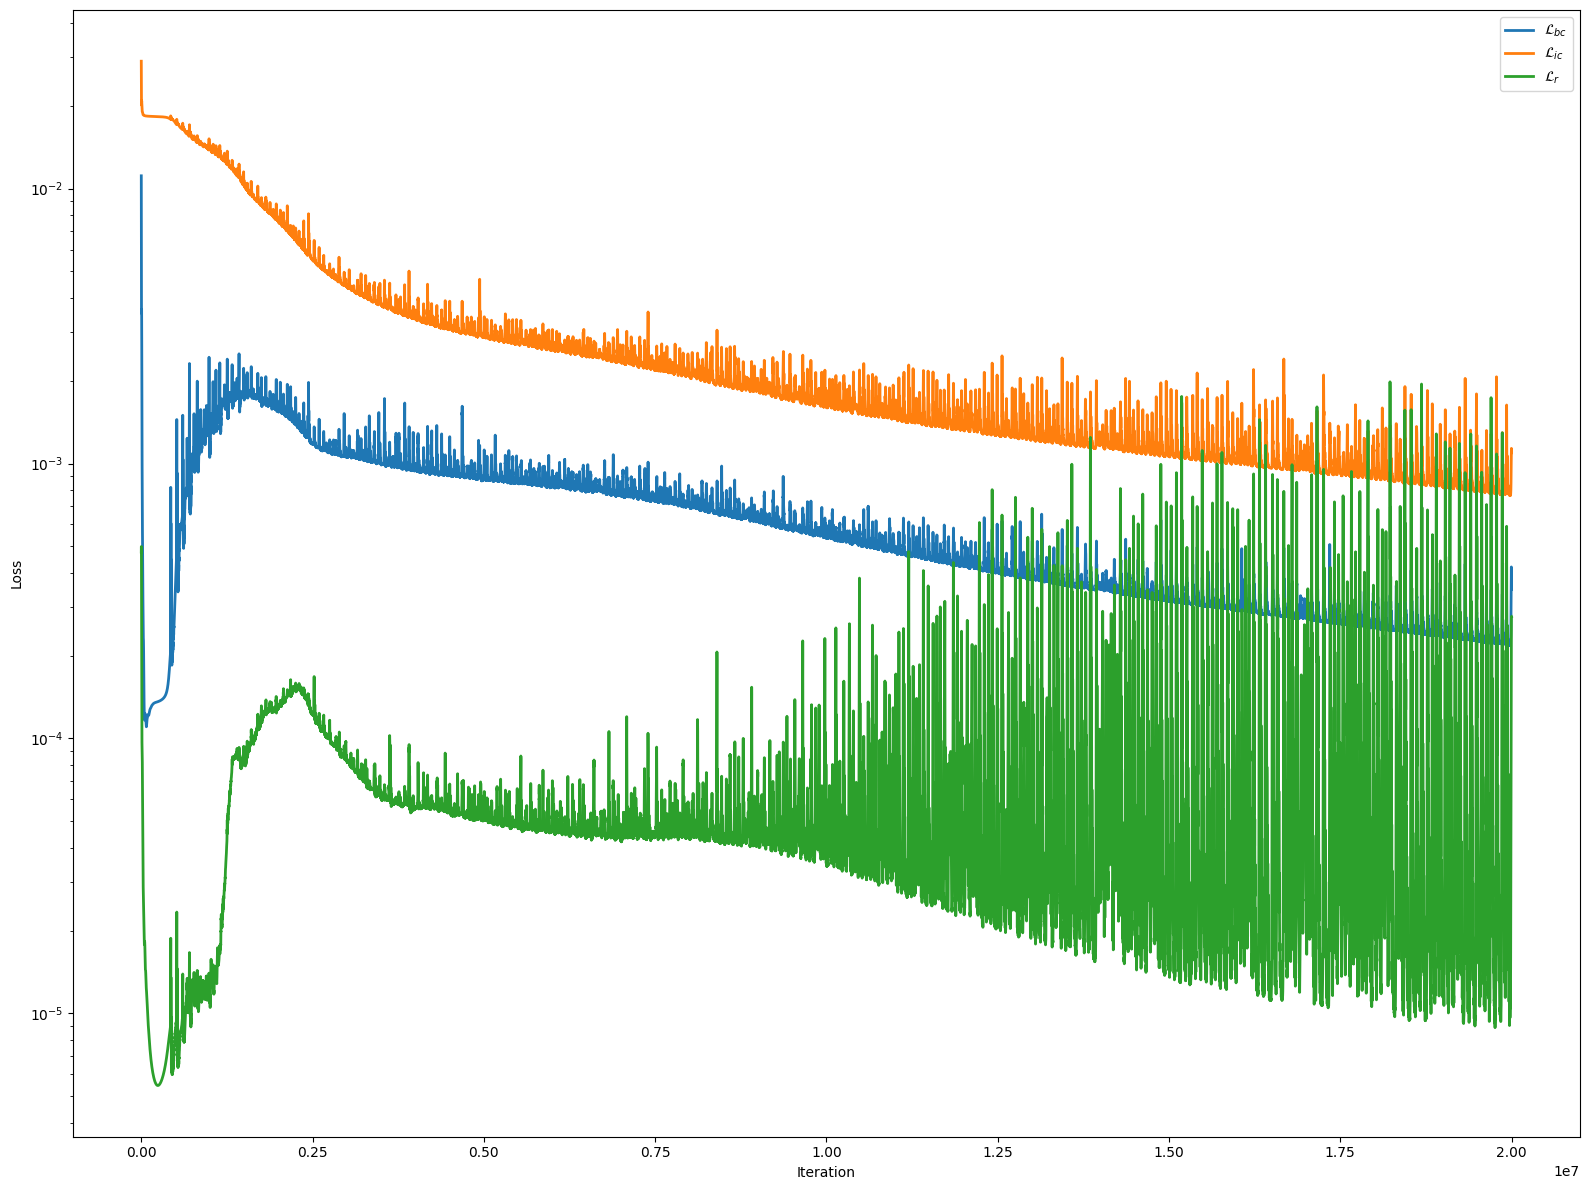

In [64]:
# Losses
fig = plt.figure(figsize=(16, 12))

iters = 1000 * np.arange(len(loss_ics))
plt.plot(iters, loss_bcs, lw=2, label='$\mathcal{L}_{bc}$')
plt.plot(iters, loss_ics, lw=2, label='$\mathcal{L}_{ic}$')
plt.plot(iters, loss_res, lw=2, label='$\mathcal{L}_{r}$')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
plt.tight_layout()
plt.show()

In [66]:
# Predicted solution
T = 21
P = 21
P_test = 21

s_fn = lambda t, x: np.sin(np.pi * x) * np.cos(np.pi * 2 * t)

x = np.linspace(0, 1, P)
u = np.sin(np.pi * x)

u_test = np.tile(u, (P ** 2, 1))

x = np.linspace(0, 1, P_test)
t = np.linspace(0, 1, P_test)
TT, XX = np.meshgrid(t, x)

y_test = np.hstack([TT.flatten()[:, None], XX.flatten()[:, None]])

In [67]:
# Предсказание модели
s_pred = model.predict_s(torch.tensor(params, dtype=torch.float32), torch.tensor(u_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
S_pred = griddata(y_test, s_pred.detach().numpy(), (TT, XX), method='cubic')

for k in range(T - 1):
    u_k = S_pred[:, -1]
    u_test_k = np.tile(u_k, (P_test ** 2, 1))
    s_pred_k = model.predict_s(torch.tensor(params, dtype=torch.float32), torch.tensor(u_test_k, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    S_pred_k = griddata(y_test, s_pred_k.detach().numpy().flatten(), (TT, XX), method='cubic')
    S_pred = np.hstack([S_pred, S_pred_k])

TypeError: must be real number, not generator

In [ ]:
# Точное решение
Nx = 21
Nt = 21 * T

x = np.linspace(0, 1, Nx)
t = np.linspace(0, T, Nt)
TT, XX = np.meshgrid(t, x)

S_test = np.sin(np.pi * XX) * np.cos(np.pi * 2 * TT)

In [ ]:
# Относительная ошибка
error = np.linalg.norm(S_pred - S_test, 2) / np.linalg.norm(S_test, 2)
print('Relative l2 error: {:.3e}'.format(error))

NameError: name 'S_pred' is not defined

# Graphs


In [ ]:
fig = plt.figure(figsize=(16, 12))

plt.subplot(3, 1, 1)
plt.pcolor(TT, XX, S_test, cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Exact')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 2)
plt.pcolor(TT, XX, S_pred, cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.title('Predicted')
plt.colorbar()
plt.tight_layout()

plt.subplot(3, 1, 3)
plt.pcolor(TT, XX, np.abs(S_pred - S_test), cmap='jet')
plt.xlabel('$t$')
plt.ylabel('$x$')
plt.colorbar()
plt.title('Absolute error')
plt.tight_layout()
plt.show()

In [ ]:
# Exact solution
Nx = 21
Nt = 21

x = torch.linspace(0, 1, Nx)
t = torch.linspace(0, 1, Nt)

grid = torch.cartesian_prod(x, t)

In [ ]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

xs = grid[:, 0].detach().numpy().reshape(-1)
ys = grid[:, 1].detach().numpy().reshape(-1)
zs = s_pred.detach().numpy()

ax.plot_trisurf(xs, ys, zs, cmap=plt.cm.jet, linewidth=0.2, alpha=1)
ax.set_title('PI DeepONet solution (3D)')
ax.set_xlabel("$x$")
ax.set_ylabel("$t$")

plt.show()